# The Boston Housing Dataset

This dataset contains information collected by the U.S Census Service concerning housing in the area of Boston Mass. 

We use this dataset to predict Median value of owner-occupied homes (MEDV) based on remaining atributes.
We are performing classical regression task. 

## Atributes:
There are 14 attributes in each case of the dataset. They are:

| Attribute | Explanation |
| :--------- | :----------- |
| CRIM | per capita crime rate by town |
| ZN | proportion of residential land zoned for lots over 25,000 sq.ft. |
| INDUS | proportion of non-retail business acres per town. |
| CHAS | Charles River dummy variable (1 if tract bounds river; 0 otherwise) |
| NOX | nitric oxides concentration (parts per 10 million) |
| RM | average number of rooms per dwelling |
| AGE | proportion of owner-occupied units built prior to 1940 |
| DIS | weighted distances to five Boston employment centres |
| RAD | index of accessibility to radial highways |
| TAX | full-value property-tax rate per 10,000 dollars |
| PTRATIO | pupil-teacher ratio by town |
| B | 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town |
| LSTAT | % lower status of the population |
| MEDV | Median value of owner-occupied homes in 1000's dollars |

In [241]:
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from wandb.keras import WandbCallback
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
from torch import nn
import pandas as pd
import numpy as np
import torch
import wandb

In [242]:
config = dict(
    data_flag = 'boston-housing',
    epochs = 200,
    learning_rate = 0.01,
    optimizer = 'adam',
    loss_fn = 'mse'
)

wandb.login()
wandb.init(project='boston-housing-regression', config=config)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,75
best_val_loss,4.09547
epoch,199
loss,10.64085
val_loss,14.51138


In [243]:
print("TF: ", tf.__version__)
print("W&B: ", wandb.__version__)

TF:  2.8.0
W&B:  0.12.11


### Get dataset
Import downloaded dataset using pandas

In [244]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
data_raw = pd.read_csv('./data/housing.csv', header=None, delimiter=r"\s+", names=column_names)

data = data_raw.copy()

### Split the data into train, validate and test

Split the dataset into a training set, validation set a test set, **in ratio of 80:10:10**

We will use the test set in the final evaluation of our model

In [245]:
train_data = data.sample(frac=0.9, random_state=0)
test_data = data.drop(train_data.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

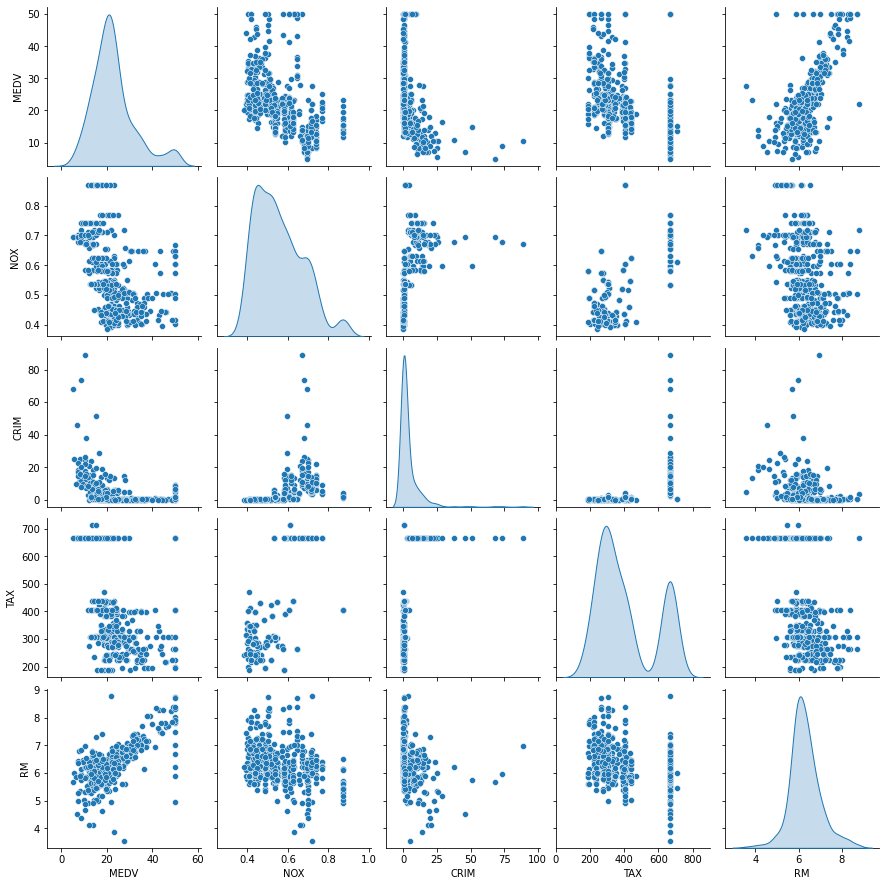

In [246]:
sns.pairplot(train_data[['MEDV', 'NOX', 'CRIM', 'TAX', 'RM']], diag_kind='kde')

Also look at the overall statistics:

In [247]:
train_stats = train_data.describe()
train_stats.pop("MEDV")
train_stats = train_stats.transpose()
# train_stats

### Split features from labels

Separate the target value (labels), from the features. Label is the value that we will train the model to predict.

In [248]:
train_labels = train_data.pop('MEDV')
test_labels = test_data.pop('MEDV')

### Normalize the data

If we look at `train_stats` we see that our features are quite different in ranges. That's why we normalize data. It also helps to prevent model from being dependent of units of input data.
We also need to project the test dataset into the same distribution that the model has been trained on, so we normalize both train and test data.

This normalized data is what we will use to train and test the model.

In [249]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_data)
normed_test_data = norm(test_data)

## The Keras model

### MPL Architecture

We'll create our model layer-by-layer, so we use a Sequential model with: 

- The normalization layer for a multiple-input model
- Two hidden, non-linear, Dense layers with the ReLU (relu) activation function.
- A linear Dense single-output layer.

Explanation:

- Number of input neurons is equal to number input features, in our case it's 13.
- To add non-linearity to regression function, we use two extra hidden layers, 5 neurons each.
- Since we are interested only in price (single value), one output neuron is enought.

Shape of our network is similar to funnel, since we are trying to concentrate many information into single value.

In [250]:
def build_model(config):
  model = keras.Sequential([
    layers.Dense(13, input_shape=(13,), activation='relu'),
    layers.Dense(5, activation='relu'),
    layers.Dense(5, activation='relu'),
    # regression - no activation function in needed the last layer
    layers.Dense(1)
  ])

  model.compile(loss=config['loss_fn'],
                optimizer=tf.optimizers.Adam(learning_rate=config['learning_rate']))
                # optimizer = tf.keras.optimizers.RMSprop(0.001))
  return model

In [251]:
model = build_model(config)

### Inspect the model

Use the .summary method to print a simple description of the model

In [252]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 13)                182       
                                                                 
 dense_25 (Dense)            (None, 5)                 70        
                                                                 
 dense_26 (Dense)            (None, 5)                 30        
                                                                 
 dense_27 (Dense)            (None, 1)                 6         
                                                                 
Total params: 288
Trainable params: 288
Non-trainable params: 0
_________________________________________________________________


### Train the model

Train the model for 200 epochs, and record the training and validation accuracy in the history object as well as to WandB API

Have closer look at parameter `validation_split` that extracts validation set from trainnig samples

In [253]:
%%time

history = model.fit(
  normed_train_data, train_labels,
  epochs=config['epochs'], validation_split=0.11, verbose=0, callbacks=[WandbCallback()])


CPU times: total: 14.4 s
Wall time: 12 s


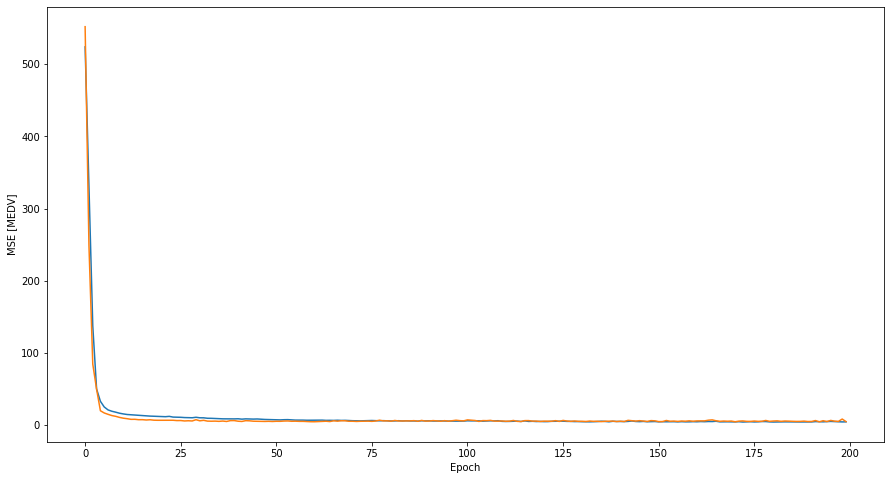

In [254]:
plt.figure(figsize=(15,8))

plt.xlabel('Epoch')
plt.ylabel('MSE [MEDV]')

plt.plot(model.history.history['loss'][:])
plt.plot(model.history.history['val_loss'][:])

### Validate model

Finally, predict MEDV values using data in the testing set and compare MAE of predicted values with mean of all house prices:

In [255]:
prediction_2d = model.predict(normed_test_data)
mae = mean_absolute_error(test_labels, prediction_2d)

print(f"We are off on average by {round(mae * 1000, 2)} US dollars, while the mean price of a house in the dataset is {round(data['MEDV'].mean() * 1000, 2)}.")

We are off on average by 1994.43 US dollars, while the mean price of a house in the dataset is 22532.81.


Visualization of predicted values compared to real ones from test set

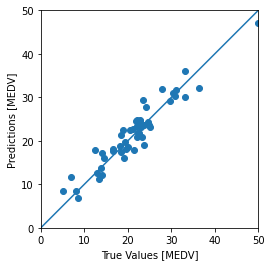

In [256]:
prediction_1d = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, prediction_1d)
plt.xlabel('True Values [MEDV]')
plt.ylabel('Predictions [MEDV]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

Visualization of many predictions were off by prediciton error

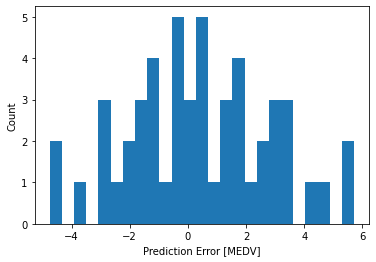

In [257]:
error = prediction_1d - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MEDV]")
_ = plt.ylabel("Count")

Some predicted values:

## The Pytorch model


In [258]:
progres_print_rate = 10
batch_size = 1024

## Decide whatever pytorch can use Cuda

In [259]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
print(device)

cuda


## Data handling
create new instance of data and split into train, test and validate dataset, **in ratio of 80:10:10**
for this we used train_test_split() from **sklearn**. 

In [260]:
data = data_raw.copy()

train, _test = train_test_split(data,  test_size = 0.2, shuffle=True)
test, validate = train_test_split(_test, test_size = 0.5)

train_targets = train.pop("MEDV")
test_targets = test.pop("MEDV")
validate_targets = validate.pop('MEDV')

train_stats = train.describe()
train_stats = train_stats.transpose()

## Data to tensor
Pytorch uses a special form representing data while training -> DataLoader
to convert pandas to DataLoader we needed to convert it to tensor and then to TensorDataset witch DataLoader uses as input

In [261]:
def df_to_tensor(df):
    return torch.from_numpy(df.values).float().to(device)

In [262]:
train_dataset = TensorDataset(df_to_tensor(norm(train)), torch.Tensor([[x] for x in list(train_targets)]))
validate_dataset = TensorDataset(df_to_tensor(norm(validate)), torch.Tensor([[x] for x in list(validate_targets)]))
x_test, y_test = (df_to_tensor(norm(test)),[x for x in list(test_targets)])

train_dataloader = DataLoader(train_dataset,batch_size=batch_size)
validate_dataloader = DataLoader(validate_dataset,batch_size=batch_size)

## Model Definition
Models architecture coresponds with the model used in keras implementation.

In [263]:
class NeuralNetwork(nn.Module):
    def __init__(self,in_size, out_size):
        super(NeuralNetwork, self).__init__()
        # self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_size, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5, out_size),
            )

    def forward(self, x):
        # x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

## Initialization of model, MSE Loss function and Adam Optimizer

In [264]:
model = NeuralNetwork(13, 1).to(device)
loss_fun = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

## Training and Validation

In [265]:
# Utility function to train the model
def fit(num_epochs, model, loss_fun, optimizer, train_dl):

    # Repeat for given number of epochs
    for epoch in range(num_epochs):
        # Train with batches of data
        for (xb, yb) in train_dl:
            # send to device whatever GPU or CPU
            xb = xb.to(device)
            yb = yb.to(device)
            # 1. Generate predictions from xb data
            pred = model(xb)
            # 2. Calculate loss with targets of xb -> yb
            loss = loss_fun(pred, yb)
            # 3. Compute gradients
            loss.backward()
            # 4. Update parameters using gradients
            optimizer.step()
            # 5. Reset the gradients to zero
            optimizer.zero_grad()
            # 6. Track with wandb
            wandb.log({"loss": loss})
            wandb.watch(model)
            # 7. Validate model - could be every 'progres_print_rate' but this gives better visualisation with wand and coresponds with Keras
            validation_output = validate_model(loader=validate_dataloader, model=model, loss_fun=loss_fun)
            
        # Print the progress
        if (epoch+1) % progres_print_rate == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
            print(validation_output)
            
def validate_model(loader, model, loss_fun):                       
    running_loss = 0.0                                        
    model.eval()                                              
    with torch.no_grad():                                     
        for _, (xb, yb) in enumerate(loader):                 
            xb = xb.to(device)                        
            yb = yb.to(device)                                                                  
            pred = model(xb)                           
            loss = loss_fun(pred, yb)                 
            running_loss = running_loss + loss.item()   
                  
            wandb.log({"val_loss": running_loss})
            wandb.watch(model)
            
    mean_val_loss = (running_loss)                  
    return 'Validation Loss:', mean_val_loss

In [266]:
fit(config['epochs'], model, loss_fun, optimizer, train_dataloader)

Epoch [10/200], Loss: 588.7449
('Validation Loss:', 646.8334350585938)
Epoch [20/200], Loss: 557.8763
('Validation Loss:', 617.2556762695312)
Epoch [30/200], Loss: 485.8250
('Validation Loss:', 547.1087036132812)
Epoch [40/200], Loss: 331.1577
('Validation Loss:', 393.137451171875)
Epoch [50/200], Loss: 149.2752
('Validation Loss:', 218.0803985595703)
Epoch [60/200], Loss: 103.7231
('Validation Loss:', 163.4895477294922)
Epoch [70/200], Loss: 71.9863
('Validation Loss:', 137.1385040283203)
Epoch [80/200], Loss: 51.8299
('Validation Loss:', 101.77606201171875)
Epoch [90/200], Loss: 40.8886
('Validation Loss:', 79.33546447753906)
Epoch [100/200], Loss: 32.8299
('Validation Loss:', 68.72500610351562)
Epoch [110/200], Loss: 27.9777
('Validation Loss:', 60.712337493896484)
Epoch [120/200], Loss: 24.9256
('Validation Loss:', 54.39432907104492)
Epoch [130/200], Loss: 23.1651
('Validation Loss:', 51.28847885131836)
Epoch [140/200], Loss: 22.0500
('Validation Loss:', 48.5711555480957)
Epoch [15

In [267]:
#Converting predictions from tensor objects into a list
y_pred_test = model(x_test)
y_pred_test = [y_pred_test[x].item() for x in range(len(y_pred_test))]

# Comparing Actual and predicted values
df = {}
df['Actual Prices'] = np.multiply(y_test,1000)
df['Predicted Prices'] = np.multiply(y_pred_test,1000) 
df = pd.DataFrame(df)
# print(df)

### Validate model

Finally, predict MEDV values using data in the testing set and compare MAE of predicted values with mean of all house prices:

In [268]:
# Let's check how much we are off on average
mae = mean_absolute_error(df['Actual Prices'], df['Predicted Prices'])

print(f"We are off on average by {round(mae, 2)} US dollars, while the mean price of a house in the dataset is {round(test_targets.mean()*1000, 2)}.")

We are off on average by 2921.15 US dollars, while the mean price of a house in the dataset is 21437.25.


Visualization of predicted values compared to real ones from test set

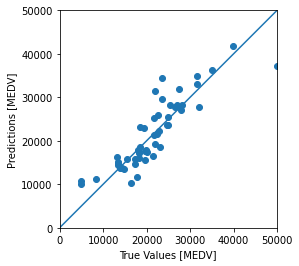

In [269]:
a = plt.axes(aspect='equal')
plt.scatter(df['Actual Prices'],  df['Predicted Prices'])
plt.xlabel('True Values [MEDV]')
plt.ylabel('Predictions [MEDV]')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

Visualization of many predictions were off by prediciton error

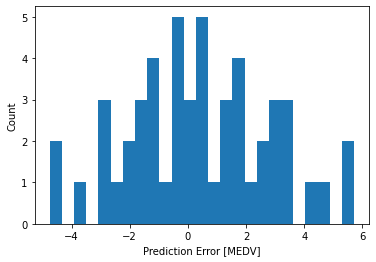

In [270]:
error = prediction_1d - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MEDV]")
_ = plt.ylabel("Count")